In [1]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')
# %cd /content/drive/MyDrive/group-1.3-master/group-1.3-master/LeverageJustAFewKeywords/
# %cd /content/drive/MyDrive/LeverageJustAFewKeywords/
%cd /content/drive/MyDrive/group-1.3/LeverageJustAFewKeywords/


Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1n0oSoMBR4TlxDwAce51xBgon3LxJjCkE/group-1.3/LeverageJustAFewKeywords


In [2]:
!pip install mittens
import csv
import numpy as np
from mittens import GloVe, Mittens
from sklearn.feature_extraction.text import CountVectorizer
import os
from time import time
import pickle
import tensorflow as tf
from collections import defaultdict
import nltk
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Word Embedding Processing

pipeline: articles & comments -> tokenize, lemmetize -> get tf1 items -> remove tf1 items -> load pre-trained embedding from GoogleNews -> fine-tune

In [3]:
import gensim
import logging
import os
import pandas as pd
from gensim.models import Word2Vec, KeyedVectors
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import numpy as np
import pickle
from time import time
# use gensim==3.8, there is a problem when using intersect_word2vec_format in gensim==4.0 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

TODO:
- more on cleaning data, especially article -> done: processed_articles
- improve efficiency of remove tf1 terms -> done
- remove tf-high terms

In [87]:
article_file = "../processed/processed_articles.pkl"
comment_file = "../processed/processed_comments.pkl"
df_article = pd.read_pickle(article_file)
df_comment = pd.read_pickle(comment_file)
print(df_article.head())
print(df_comment.head())

                                             article
0  Supposed climate independent food research gro...
1  A form of what is now called regenerative agri...
2  Did you know the majority of olive oil sold in...
3  Even light doses of glyphosate can cause disea...
4  NEW REPORT: Natural climate solutions—includin...
                                             comment
0                   That was another administration.
1  Why is the ex CEO of Monsanto appointed head o...
2  because he greased the palms of our "elected" ...
3  the photo shown above is from a feed lot in Ca...
4  THAT IS NOT GRASS FED MEET! NO GRASS THERE! YO...


In [88]:
article_list = df_article.article.astype('str').tolist()
comment_list = df_comment.comment.astype('str').tolist()
corpus = article_list + comment_list
print(len(article_list), len(comment_list), len(corpus))
# before processing articles: 4633 135479 140112
# after processing articles: 4451 135479 139963
# after re-processing comments: 4451 129307 133758
# after fixing issue of missing punctuation marks: 4479 130516 134995

4479 130516 134995


In [89]:
print(article_list[0], '\n\n', comment_list[0], '\n')
print(corpus[:5])

Supposed climate independent food research group claims grass-fed beef and CAFOs have the same climate impacts. This absurd statement likely stems from the group’s cozy ties to Monsanto. 

 That was another administration. 

['Supposed climate independent food research group claims grass-fed beef and CAFOs have the same climate impacts. This absurd statement likely stems from the group’s cozy ties to Monsanto.', 'A form of what is now called regenerative agriculture, or regenerative organic agriculture, was practiced over thousands of years ago by Mayan and indigenous people throughout the Americas.', "Did you know the majority of olive oil sold in stores is fake? Here's how to spot the phony ones.", 'Even light doses of glyphosate can cause disease in organs later on, says a biologist opposed to spraying the herbicide to kill weeds and young hardwoods in New Brunswick and elsewhere.', 'NEW REPORT: Natural climate solutions—including regenerative farming and land management—could reduc

In [90]:
# processing with stop words and lemmatizing
def tokenize_sentence(sent):
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_sent = tokenizer.tokenize(sent)
    return tokenized_sent

def lemmatize_sentence(sent):
    lemmatier = WordNetLemmatizer()
    if isinstance(sent, str):   # raw sentence
        sent = tokenize_sentence(sent)
    tokens = [lemmatier.lemmatize(token) for token in sent]
    return tokens

def remove_wordlist(sent, word_list=None):
    if isinstance(sent, str):
        sent = tokenize_sentence(sent)
    if word_list:
        tokens = [token for token in sent if token not in word_list]
    return tokens

def process_text(text_list, tokenize=True, lemmatize=True, stop_words=None):
    '''
    text_list: list of strings or list of tokens list
    '''
    if tokenize:
        text_list = [s.lower() for s in text_list]
        print('tokenize sentence')
        text_list = [tokenize_sentence(s) for s in text_list]
        # tokenizer = RegexpTokenizer(r'\w+')
        # tokenized_text = [s.lower() for s in text_list]
        # tokenized_text = [tokenizer.tokenize(s) for s in tokenized_text]
        # text_list = tokenized_text
    # processed_text = []
    # for tokens in tqdm(text_list):
    #     if stop_words != None:
    #         tokens = [token for token in tokens if token not in stop_words]
    #     if lemmatize:
    #         lemmatizer = WordNetLemmatizer()
    #         tokens = [lemmatizer.lemmatize(token) for token in tokens]
    #     processed_text.append(tokens)
    if lemmatize:
        print('lemmatize sentence')
        text_list = [lemmatize_sentence(s) for s in text_list]
    if stop_words:
        print('remove word list')
        text_list = [remove_wordlist(s, stop_words) for s in text_list]
    return text_list
# tokenizer = RegexpTokenizer(r'\w+')
# corpus_tokenized = [s.lower() for s in corpus]
# corpus_tokenized = [tokenizer.tokenize(i) for i in corpus_tokenized]

tokenize and lemmatize the corpus to get `init_corpus`

In [91]:
%%time
init_corpus = process_text(corpus, tokenize=True, lemmatize=True)

tokenize sentence
lemmatize sentence
CPU times: user 43 s, sys: 766 ms, total: 43.8 s
Wall time: 43.9 s


In [92]:
for i in range(5):
    print(init_corpus[i])

['supposed', 'climate', 'independent', 'food', 'research', 'group', 'claim', 'grass', 'fed', 'beef', 'and', 'cafos', 'have', 'the', 'same', 'climate', 'impact', 'this', 'absurd', 'statement', 'likely', 'stem', 'from', 'the', 'group', 's', 'cozy', 'tie', 'to', 'monsanto']
['a', 'form', 'of', 'what', 'is', 'now', 'called', 'regenerative', 'agriculture', 'or', 'regenerative', 'organic', 'agriculture', 'wa', 'practiced', 'over', 'thousand', 'of', 'year', 'ago', 'by', 'mayan', 'and', 'indigenous', 'people', 'throughout', 'the', 'america']
['did', 'you', 'know', 'the', 'majority', 'of', 'olive', 'oil', 'sold', 'in', 'store', 'is', 'fake', 'here', 's', 'how', 'to', 'spot', 'the', 'phony', 'one']
['even', 'light', 'dos', 'of', 'glyphosate', 'can', 'cause', 'disease', 'in', 'organ', 'later', 'on', 'say', 'a', 'biologist', 'opposed', 'to', 'spraying', 'the', 'herbicide', 'to', 'kill', 'weed', 'and', 'young', 'hardwood', 'in', 'new', 'brunswick', 'and', 'elsewhere']
['new', 'report', 'natural', '

In [93]:
def cal_num_tokens(text):
    num_tokens = 0
    for s in text:
        num_tokens += len(s)
    return num_tokens

In [94]:
cal_num_tokens(init_corpus)
# 8919385
# after re-process comment: 8712655
# after fixing issue of missing punctuation marks: 8733083

8733083

deal with low TF words

In [95]:
model_tf1 = Word2Vec(min_count=1, sorted_vocab=1)
# model.build_vocab(sentences_tokenized)
model_tf1.build_vocab(init_corpus)
print(model_tf1.wv.vectors.shape)
# before processing articles (05.16): (88987, 100)
# after processing articles (06.27): (87917, 100)
# after re-process comment (07.04): (80420, 100)
# after fixing issue of missing punctuation marks (07.16): (80591, 100)

2021-07-17 16:33:13,063 : INFO : collecting all words and their counts
2021-07-17 16:33:13,065 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-17 16:33:13,811 : INFO : PROGRESS: at sentence #10000, processed 2726483 words, keeping 44963 word types
2021-07-17 16:33:13,892 : INFO : PROGRESS: at sentence #20000, processed 2967290 words, keeping 47401 word types
2021-07-17 16:33:13,974 : INFO : PROGRESS: at sentence #30000, processed 3254721 words, keeping 49924 word types
2021-07-17 16:33:14,065 : INFO : PROGRESS: at sentence #40000, processed 3572800 words, keeping 52232 word types
2021-07-17 16:33:14,144 : INFO : PROGRESS: at sentence #50000, processed 3828047 words, keeping 54005 word types
2021-07-17 16:33:14,214 : INFO : PROGRESS: at sentence #60000, processed 4089115 words, keeping 55896 word types
2021-07-17 16:33:14,309 : INFO : PROGRESS: at sentence #70000, processed 4373159 words, keeping 57935 word types
2021-07-17 16:33:14,403 : INFO : PROGRE

(80591, 100)


In [96]:
# vocab example
print(model_tf1.wv.vocab['being'])
print(model_tf1.wv.index2word[0])
print(model_tf1.wv.vocab['the'])

Vocab(count:9124, index:127, sample_int:4294967296)
the
Vocab(count:373217, index:0, sample_int:757496327)


In [97]:
sorted_vocab = sorted(model_tf1.wv.vocab.items(), key=lambda item:item[1].count, reverse=True)
sorted_vocab[:5]
# the, and, to, a, of

[('the', <gensim.models.keyedvectors.Vocab at 0x7f4749311490>),
 ('and', <gensim.models.keyedvectors.Vocab at 0x7f47493ec310>),
 ('to', <gensim.models.keyedvectors.Vocab at 0x7f47471c2a10>),
 ('a', <gensim.models.keyedvectors.Vocab at 0x7f47494500d0>),
 ('of', <gensim.models.keyedvectors.Vocab at 0x7f47492e66d0>)]

In [98]:
vocab_count = {token: vocab.count for token, vocab in sorted_vocab}
print({k: vocab_count[k] for k in list(vocab_count.keys())[:50]})

{'the': 373217, 'and': 238314, 'to': 234642, 'a': 215635, 'of': 193159, 'is': 170940, 'in': 133585, 'that': 128526, 'it': 121528, 'i': 109599, 'not': 97703, 'are': 95187, 'for': 88085, 'food': 81925, 'you': 81151, 'organic': 75743, 'have': 59026, 'they': 55585, 'on': 55347, 'with': 51947, 'be': 50513, 's': 47905, 'this': 47152, 'we': 46820, 'but': 42460, 'do': 41960, 'or': 41078, 'from': 39548, 'more': 36002, 'all': 32964, 'can': 32148, 'if': 32008, 'at': 31794, 'what': 30656, 'their': 30118, 'by': 29801, 'will': 29381, 'there': 29265, 'so': 28981, 'about': 28720, 'your': 27839, 'ha': 26262, 'people': 24984, 'no': 24556, 'wa': 23887, 'an': 23803, 'would': 22898, 'my': 22623, 'one': 22609, 'our': 22372}


In [99]:
%%time
TF1_list = []
count_list = []
for token, vocab in model_tf1.wv.vocab.items():
    count_list.append(vocab.count)
    if vocab.count == 1:
        TF1_list.append(token)

CPU times: user 54.1 ms, sys: 0 ns, total: 54.1 ms
Wall time: 54.2 ms


In [100]:
print(len(TF1_list))
print(TF1_list[-20:])
# 36290
# after fixing issue of missing punctuation marks: 36365

36365
['exeptions', 'foodinsight', '4800', 'nonpatented', 'farmand', 'atrociously', 'ruminate', 'micki', 'manily', 'stilll', 'volitization', 'disfavored', 'aril', 'kolana', 'graving', 'tsarist', 'woodcraft', 'exclsively', 'amishgirlscancook', 'chemies']


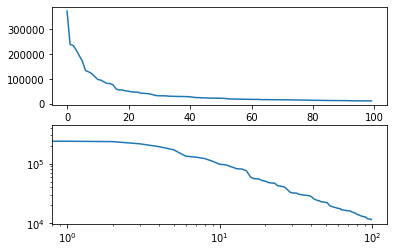

In [101]:
n_vocab = model_tf1.wv.vectors.shape[0]
n_plot = 100
plt.subplot(211)
plt.plot(np.arange(n_plot), sorted(count_list, reverse=True)[:n_plot])
# plt.yscale('log')
plt.subplot(212)
plt.loglog(np.arange(n_plot), sorted(count_list, reverse=True)[:n_plot])
plt.show()

remove tf1 items

In [102]:
def find_token_index(corpus, token):
    for i, tokens in enumerate(corpus):
        if token in tokens:
            print(i, tokens.index(token))

In [103]:
find_token_index(init_corpus, TF1_list[-1])

134987 14


In [104]:
print(len(set(TF1_list)))
# print(set(TF1_list))

36365


remove tf1 terms, already tokenize and lemmatize

In [105]:
corpus_wotf1 = process_text(init_corpus, tokenize=False, lemmatize=False, stop_words=set(TF1_list))

remove word list


In [106]:
for i in range(5):
    print(corpus_wotf1[i])

['supposed', 'climate', 'independent', 'food', 'research', 'group', 'claim', 'grass', 'fed', 'beef', 'and', 'cafos', 'have', 'the', 'same', 'climate', 'impact', 'this', 'absurd', 'statement', 'likely', 'stem', 'from', 'the', 'group', 's', 'cozy', 'tie', 'to', 'monsanto']
['a', 'form', 'of', 'what', 'is', 'now', 'called', 'regenerative', 'agriculture', 'or', 'regenerative', 'organic', 'agriculture', 'wa', 'practiced', 'over', 'thousand', 'of', 'year', 'ago', 'by', 'mayan', 'and', 'indigenous', 'people', 'throughout', 'the', 'america']
['did', 'you', 'know', 'the', 'majority', 'of', 'olive', 'oil', 'sold', 'in', 'store', 'is', 'fake', 'here', 's', 'how', 'to', 'spot', 'the', 'phony', 'one']
['even', 'light', 'dos', 'of', 'glyphosate', 'can', 'cause', 'disease', 'in', 'organ', 'later', 'on', 'say', 'a', 'biologist', 'opposed', 'to', 'spraying', 'the', 'herbicide', 'to', 'kill', 'weed', 'and', 'young', 'hardwood', 'in', 'new', 'brunswick', 'and', 'elsewhere']
['new', 'report', 'natural', '

In [107]:
cal_num_tokens(corpus_wotf1)
# after process articles: 8878299
# after re-process comments: 8676365
# after fixing issue of missing punctuation marks: 8696718

8696718

In [29]:
model_tf2 = Word2Vec(min_count=2, sorted_vocab=1, sample = 0) # alternate method?
# model.build_vocab(sentences_tokenized)
model_tf2.build_vocab(init_corpus)
print(model_tf2.wv.vectors.shape)

2021-07-17 13:13:23,850 : INFO : collecting all words and their counts
2021-07-17 13:13:23,860 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-17 13:13:24,425 : INFO : PROGRESS: at sentence #10000, processed 2726483 words, keeping 44963 word types
2021-07-17 13:13:24,487 : INFO : PROGRESS: at sentence #20000, processed 2967290 words, keeping 47401 word types
2021-07-17 13:13:24,555 : INFO : PROGRESS: at sentence #30000, processed 3254721 words, keeping 49924 word types
2021-07-17 13:13:24,629 : INFO : PROGRESS: at sentence #40000, processed 3572800 words, keeping 52232 word types
2021-07-17 13:13:24,691 : INFO : PROGRESS: at sentence #50000, processed 3828047 words, keeping 54005 word types
2021-07-17 13:13:24,755 : INFO : PROGRESS: at sentence #60000, processed 4089115 words, keeping 55896 word types
2021-07-17 13:13:24,824 : INFO : PROGRESS: at sentence #70000, processed 4373159 words, keeping 57935 word types
2021-07-17 13:13:24,903 : INFO : PROGRE

(44226, 100)


In [ ]:
vocab2 = list(model_tf2.wv.vocab.keys())
# print(vocab2[:5])
# print(len(vocab2))
corpus_rmtf1 = []
for token in tqdm(init_corpus):
  if token in vocab2:
    corpus_rmtf1.append(token)

In [ ]:
# very slow: maybe cost much time to check if a token is in a huge list, manually distribute to different notebook duplicates and each for some part
# clean_corpus = process_text(corpus[120000:], lemmatize=True, stop_words=TF1_list)
# 100%|██████████| 20112/20112 [1:26:41<00:00,  3.87it/s]

100%|██████████| 20112/20112 [1:26:41<00:00,  3.87it/s]


In [108]:
def pickle_save(clean_corpus, filename):
    with open(filename, 'wb') as f:
        pickle.dump(clean_corpus, f)

def pickle_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [ ]:
# save_file = "../processed/corpus_wotf1_12_end.pkl"
# pickle_save(save_file)

In [ ]:
# corpus_eg = pickle_load("../processed/corpus_wotf1_10_12.pkl")

In [ ]:
# print(corpus_eg[0])
# ['where', 'did', 'i', 'say', 'no', 'real', 'consequence']

['where', 'did', 'i', 'say', 'no', 'real', 'consequence']


In [ ]:
# clean_corpus = []
# root = "../processed"
# for f in os.listdir(root):
#     if f.startswith("corpus_wotf1_"):
#         print(f)
#         clean_corpus += pickle_load(os.path.join(root, f))
# print(len(clean_corpus))
# # corpus_wotf1_4_8.pkl
# # corpus_wotf1_8_10.pkl
# # corpus_wotf1_0_4.pkl
# # corpus_wotf1_10_12.pkl
# # corpus_wotf1_12_end.pkl
# # 140112

corpus_wotf1_4_8.pkl
corpus_wotf1_8_10.pkl
corpus_wotf1_0_4.pkl
corpus_wotf1_10_12.pkl
corpus_wotf1_12_end.pkl
140112


remove stopwords 

In [109]:
nltk_stw = set(stopwords.words('english'))
print(sorted(nltk_stw))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

In [110]:
corpus_wotf1_wostw = process_text(corpus_wotf1, tokenize=False, lemmatize=False, stop_words=nltk_stw)

remove word list


In [111]:
for i in range(5):
    print(corpus_wotf1_wostw[i])

['supposed', 'climate', 'independent', 'food', 'research', 'group', 'claim', 'grass', 'fed', 'beef', 'cafos', 'climate', 'impact', 'absurd', 'statement', 'likely', 'stem', 'group', 'cozy', 'tie', 'monsanto']
['form', 'called', 'regenerative', 'agriculture', 'regenerative', 'organic', 'agriculture', 'wa', 'practiced', 'thousand', 'year', 'ago', 'mayan', 'indigenous', 'people', 'throughout', 'america']
['know', 'majority', 'olive', 'oil', 'sold', 'store', 'fake', 'spot', 'phony', 'one']
['even', 'light', 'dos', 'glyphosate', 'cause', 'disease', 'organ', 'later', 'say', 'biologist', 'opposed', 'spraying', 'herbicide', 'kill', 'weed', 'young', 'hardwood', 'new', 'brunswick', 'elsewhere']
['new', 'report', 'natural', 'climate', 'solution', 'including', 'regenerative', 'farming', 'land', 'management', 'could', 'reduce', 'emission', '11', '3', 'billion', 'ton', 'per', 'year', '2030']


In [112]:
cal_num_tokens(corpus_wotf1_wostw)
# 4708064
# after fixing issue of missing punctuation marks: 4720042

4720042

In [ ]:
pickle_save(corpus_wotf1, "../processed/corpus_wotf1.pkl")
pickle_save(corpus_wotf1_wostw,"../processed/corpus_wotf1_wostw.pkl")

# Fine-tune W2V


## group together

In [ ]:
group = {'corpus_wotf1': corpus_wotf1, 'corpus_wotf1_wostw': corpus_wotf1_wostw}

In [ ]:
for key, value in group.items():
    model = Word2Vec(size=300)
    model.build_vocab(value, min_count=5)
    total_examples = model.corpus_count
    print(f"{key} shape: {model.wv.vectors.shape}")
    print("loading pretrained models ...")
    model.intersect_word2vec_format('../wv/GoogleNews-vectors-negative300.bin.gz', binary=True, lockf=1.0)
    print("save intersected pretrained model ...")
    model.wv.save_word2vec_format(f"../wv/w2v_{key}_pretrained.bin", binary=True)
    print("training ...")
    model.train(value, total_examples=total_examples, epochs=100)
    model.wv.save_word2vec_format(f"../wv/w2v_{key}_tuned.bin", binary=True)

2021-07-16 12:55:27,248 : INFO : collecting all words and their counts
2021-07-16 12:55:27,249 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-16 12:55:27,728 : INFO : PROGRESS: at sentence #10000, processed 2715959 words, keeping 34439 word types
2021-07-16 12:55:27,780 : INFO : PROGRESS: at sentence #20000, processed 2955496 words, keeping 35607 word types
2021-07-16 12:55:27,837 : INFO : PROGRESS: at sentence #30000, processed 3241447 words, keeping 36650 word types
2021-07-16 12:55:27,901 : INFO : PROGRESS: at sentence #40000, processed 3558034 words, keeping 37466 word types
2021-07-16 12:55:27,955 : INFO : PROGRESS: at sentence #50000, processed 3812136 words, keeping 38094 word types
2021-07-16 12:55:28,012 : INFO : PROGRESS: at sentence #60000, processed 4071837 words, keeping 38618 word types
2021-07-16 12:55:28,067 : INFO : PROGRESS: at sentence #70000, processed 4354430 words, keeping 39206 word types
2021-07-16 12:55:28,144 : INFO : PROGRE

corpus_wotf1 shape: (25840, 300)
loading pretrained models ...


2021-07-16 12:57:33,178 : INFO : merged 22504 vectors into (25840, 300) matrix from ../wv/GoogleNews-vectors-negative300.bin.gz
2021-07-16 12:57:33,179 : INFO : storing 25840x300 projection weights into ../wv/w2v_corpus_wotf1_pretrained.bin


save intersected pretrained model ...


2021-07-16 12:57:33,483 : INFO : training model with 3 workers on 25840 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5


training ...


2021-07-16 12:57:34,527 : INFO : EPOCH 1 - PROGRESS: at 1.63% examples, 321378 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:35,533 : INFO : EPOCH 1 - PROGRESS: at 2.02% examples, 332475 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:36,537 : INFO : EPOCH 1 - PROGRESS: at 2.36% examples, 330631 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:37,551 : INFO : EPOCH 1 - PROGRESS: at 2.72% examples, 332300 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:38,583 : INFO : EPOCH 1 - PROGRESS: at 3.02% examples, 330376 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:39,583 : INFO : EPOCH 1 - PROGRESS: at 5.03% examples, 330866 words/s, in_qsize 4, out_qsize 1
2021-07-16 12:57:40,593 : INFO : EPOCH 1 - PROGRESS: at 18.54% examples, 331762 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:41,593 : INFO : EPOCH 1 - PROGRESS: at 29.51% examples, 335061 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:57:42,603 : INFO : EPOCH 1 - PROGRESS: at 42.36% examples, 335209 words/s, in_qsize 5, o

2021-07-16 12:58:38,416 : INFO : EPOCH 4 - PROGRESS: at 2.50% examples, 276956 words/s, in_qsize 6, out_qsize 0
2021-07-16 12:58:39,419 : INFO : EPOCH 4 - PROGRESS: at 2.76% examples, 271997 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:58:40,444 : INFO : EPOCH 4 - PROGRESS: at 3.00% examples, 269216 words/s, in_qsize 4, out_qsize 1
2021-07-16 12:58:41,456 : INFO : EPOCH 4 - PROGRESS: at 3.29% examples, 269466 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:58:42,466 : INFO : EPOCH 4 - PROGRESS: at 12.33% examples, 270045 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:58:43,507 : INFO : EPOCH 4 - PROGRESS: at 22.10% examples, 268099 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:58:44,548 : INFO : EPOCH 4 - PROGRESS: at 30.92% examples, 267955 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:58:45,563 : INFO : EPOCH 4 - PROGRESS: at 42.04% examples, 269906 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:58:46,581 : INFO : EPOCH 4 - PROGRESS: at 52.61% examples, 271535 words/s, in_qsize 5,

2021-07-16 12:59:43,368 : INFO : EPOCH 7 - PROGRESS: at 16.68% examples, 324988 words/s, in_qsize 4, out_qsize 1
2021-07-16 12:59:44,398 : INFO : EPOCH 7 - PROGRESS: at 27.88% examples, 327935 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:59:45,416 : INFO : EPOCH 7 - PROGRESS: at 40.84% examples, 329359 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:59:46,462 : INFO : EPOCH 7 - PROGRESS: at 53.96% examples, 330361 words/s, in_qsize 6, out_qsize 0
2021-07-16 12:59:47,465 : INFO : EPOCH 7 - PROGRESS: at 61.24% examples, 331688 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:59:48,495 : INFO : EPOCH 7 - PROGRESS: at 66.81% examples, 331758 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:59:49,528 : INFO : EPOCH 7 - PROGRESS: at 70.43% examples, 332155 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:59:50,589 : INFO : EPOCH 7 - PROGRESS: at 74.16% examples, 332393 words/s, in_qsize 5, out_qsize 0
2021-07-16 12:59:51,592 : INFO : EPOCH 7 - PROGRESS: at 79.67% examples, 332910 words/s, in_qsiz

2021-07-16 13:00:47,678 : INFO : EPOCH 10 - PROGRESS: at 66.81% examples, 332060 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:48,678 : INFO : EPOCH 10 - PROGRESS: at 70.30% examples, 332247 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:49,688 : INFO : EPOCH 10 - PROGRESS: at 73.58% examples, 332558 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:50,695 : INFO : EPOCH 10 - PROGRESS: at 79.31% examples, 333465 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:51,716 : INFO : EPOCH 10 - PROGRESS: at 83.13% examples, 333705 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:52,766 : INFO : EPOCH 10 - PROGRESS: at 87.07% examples, 333783 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:53,771 : INFO : EPOCH 10 - PROGRESS: at 92.08% examples, 334211 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:54,821 : INFO : EPOCH 10 - PROGRESS: at 98.02% examples, 334321 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:00:55,113 : INFO : worker thread finished; awaiting finish of 2 more threa

2021-07-16 13:01:51,957 : INFO : EPOCH 13 - PROGRESS: at 81.64% examples, 323499 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:01:52,972 : INFO : EPOCH 13 - PROGRESS: at 85.47% examples, 323981 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:01:53,982 : INFO : EPOCH 13 - PROGRESS: at 89.29% examples, 324817 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:01:54,984 : INFO : EPOCH 13 - PROGRESS: at 95.42% examples, 325410 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:01:55,902 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:01:55,917 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:01:55,920 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:01:55,921 : INFO : EPOCH - 13 : training on 8696718 raw words (6592897 effective words) took 20.4s, 323969 effective words/s
2021-07-16 13:01:56,950 : INFO : EPOCH 14 - PROGRESS: at 1.61% examples, 305866 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:01:57

2021-07-16 13:02:55,224 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:02:55,228 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:02:55,229 : INFO : EPOCH - 16 : training on 8696718 raw words (6593715 effective words) took 19.8s, 333737 effective words/s
2021-07-16 13:02:56,238 : INFO : EPOCH 17 - PROGRESS: at 1.62% examples, 327032 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:02:57,245 : INFO : EPOCH 17 - PROGRESS: at 1.98% examples, 316457 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:02:58,284 : INFO : EPOCH 17 - PROGRESS: at 2.31% examples, 316508 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:02:59,315 : INFO : EPOCH 17 - PROGRESS: at 2.68% examples, 317702 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:03:00,336 : INFO : EPOCH 17 - PROGRESS: at 2.97% examples, 316956 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:03:01,369 : INFO : EPOCH 17 - PROGRESS: at 3.31% examples, 320145 words/s, in_qsize 5, out_qsize 0
2

2021-07-16 13:03:57,613 : INFO : EPOCH 20 - PROGRESS: at 1.96% examples, 299574 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:03:58,638 : INFO : EPOCH 20 - PROGRESS: at 2.27% examples, 296127 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:03:59,648 : INFO : EPOCH 20 - PROGRESS: at 2.58% examples, 295590 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:04:00,664 : INFO : EPOCH 20 - PROGRESS: at 2.88% examples, 298981 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:04:01,696 : INFO : EPOCH 20 - PROGRESS: at 3.20% examples, 301698 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:04:02,724 : INFO : EPOCH 20 - PROGRESS: at 12.00% examples, 306840 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:04:03,732 : INFO : EPOCH 20 - PROGRESS: at 23.62% examples, 310338 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:04:04,746 : INFO : EPOCH 20 - PROGRESS: at 35.66% examples, 312078 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:04:05,754 : INFO : EPOCH 20 - PROGRESS: at 47.87% examples, 313786 words/s, in_

2021-07-16 13:05:03,232 : INFO : EPOCH 23 - PROGRESS: at 5.35% examples, 282314 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:04,243 : INFO : EPOCH 23 - PROGRESS: at 19.28% examples, 289893 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:05,257 : INFO : EPOCH 23 - PROGRESS: at 29.24% examples, 294538 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:06,271 : INFO : EPOCH 23 - PROGRESS: at 42.64% examples, 300052 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:07,271 : INFO : EPOCH 23 - PROGRESS: at 55.48% examples, 304260 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:08,299 : INFO : EPOCH 23 - PROGRESS: at 61.81% examples, 306897 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:09,333 : INFO : EPOCH 23 - PROGRESS: at 67.06% examples, 307102 words/s, in_qsize 5, out_qsize 1
2021-07-16 13:05:10,334 : INFO : EPOCH 23 - PROGRESS: at 70.51% examples, 309396 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:05:11,352 : INFO : EPOCH 23 - PROGRESS: at 73.58% examples, 309669 words/s,

2021-07-16 13:06:07,450 : INFO : EPOCH 26 - PROGRESS: at 62.98% examples, 343066 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:08,455 : INFO : EPOCH 26 - PROGRESS: at 68.10% examples, 342786 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:09,468 : INFO : EPOCH 26 - PROGRESS: at 71.46% examples, 341731 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:10,477 : INFO : EPOCH 26 - PROGRESS: at 75.81% examples, 342010 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:11,482 : INFO : EPOCH 26 - PROGRESS: at 80.54% examples, 341401 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:12,513 : INFO : EPOCH 26 - PROGRESS: at 84.43% examples, 341441 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:13,548 : INFO : EPOCH 26 - PROGRESS: at 88.44% examples, 341339 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:14,551 : INFO : EPOCH 26 - PROGRESS: at 94.09% examples, 341434 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:06:15,537 : INFO : worker thread finished; awaiting finish of 2 more threa

2021-07-16 13:07:12,304 : INFO : EPOCH 29 - PROGRESS: at 88.04% examples, 339443 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:07:13,304 : INFO : EPOCH 29 - PROGRESS: at 93.27% examples, 338865 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:07:14,310 : INFO : EPOCH 29 - PROGRESS: at 99.21% examples, 339486 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:07:14,405 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:07:14,429 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:07:14,440 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:07:14,441 : INFO : EPOCH - 29 : training on 8696718 raw words (6593495 effective words) took 19.4s, 339771 effective words/s
2021-07-16 13:07:15,470 : INFO : EPOCH 30 - PROGRESS: at 1.64% examples, 333489 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:07:16,473 : INFO : EPOCH 30 - PROGRESS: at 2.02% examples, 335006 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:07:17,

2021-07-16 13:08:14,088 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:08:14,120 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:08:14,121 : INFO : EPOCH - 32 : training on 8696718 raw words (6595050 effective words) took 20.9s, 315477 effective words/s
2021-07-16 13:08:15,169 : INFO : EPOCH 33 - PROGRESS: at 1.63% examples, 320346 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:08:16,195 : INFO : EPOCH 33 - PROGRESS: at 2.03% examples, 332031 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:08:17,199 : INFO : EPOCH 33 - PROGRESS: at 2.38% examples, 335173 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:08:18,229 : INFO : EPOCH 33 - PROGRESS: at 2.73% examples, 330534 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:08:19,263 : INFO : EPOCH 33 - PROGRESS: at 3.02% examples, 327424 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:08:20,273 : INFO : EPOCH 33 - PROGRESS: at 5.35% examples, 329114 words/s, in_qsize 5, out_qsize 0
2

2021-07-16 13:09:15,627 : INFO : EPOCH 36 - PROGRESS: at 2.36% examples, 330368 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:16,637 : INFO : EPOCH 36 - PROGRESS: at 2.71% examples, 328993 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:17,649 : INFO : EPOCH 36 - PROGRESS: at 3.00% examples, 327577 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:18,682 : INFO : EPOCH 36 - PROGRESS: at 4.65% examples, 329005 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:19,698 : INFO : EPOCH 36 - PROGRESS: at 18.60% examples, 330944 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:20,703 : INFO : EPOCH 36 - PROGRESS: at 29.51% examples, 334176 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:21,738 : INFO : EPOCH 36 - PROGRESS: at 43.23% examples, 335923 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:22,740 : INFO : EPOCH 36 - PROGRESS: at 55.98% examples, 337040 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:09:23,767 : INFO : EPOCH 36 - PROGRESS: at 62.14% examples, 337595 words/s, in

2021-07-16 13:10:19,121 : INFO : EPOCH 39 - PROGRESS: at 30.33% examples, 336223 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:20,137 : INFO : EPOCH 39 - PROGRESS: at 43.51% examples, 336775 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:21,141 : INFO : EPOCH 39 - PROGRESS: at 56.32% examples, 337640 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:22,150 : INFO : EPOCH 39 - PROGRESS: at 62.24% examples, 338731 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:23,153 : INFO : EPOCH 39 - PROGRESS: at 67.69% examples, 339524 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:24,171 : INFO : EPOCH 39 - PROGRESS: at 71.08% examples, 339155 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:25,185 : INFO : EPOCH 39 - PROGRESS: at 75.43% examples, 339998 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:26,218 : INFO : EPOCH 39 - PROGRESS: at 80.44% examples, 339902 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:10:27,229 : INFO : EPOCH 39 - PROGRESS: at 84.16% examples, 339978 words/s

2021-07-16 13:11:22,781 : INFO : EPOCH 42 - PROGRESS: at 71.24% examples, 338146 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:23,796 : INFO : EPOCH 42 - PROGRESS: at 75.54% examples, 338523 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:24,804 : INFO : EPOCH 42 - PROGRESS: at 80.44% examples, 338578 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:25,834 : INFO : EPOCH 42 - PROGRESS: at 84.22% examples, 338826 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:26,842 : INFO : EPOCH 42 - PROGRESS: at 88.13% examples, 338536 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:27,851 : INFO : EPOCH 42 - PROGRESS: at 93.64% examples, 338664 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:28,855 : INFO : EPOCH 42 - PROGRESS: at 99.47% examples, 338922 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:11:28,919 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:11:28,923 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:11:28,

2021-07-16 13:12:26,729 : INFO : EPOCH 45 - PROGRESS: at 91.81% examples, 333272 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:12:27,741 : INFO : EPOCH 45 - PROGRESS: at 97.78% examples, 334072 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:12:28,101 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:12:28,128 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:12:28,134 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:12:28,135 : INFO : EPOCH - 45 : training on 8696718 raw words (6594527 effective words) took 19.7s, 334116 effective words/s
2021-07-16 13:12:29,139 : INFO : EPOCH 46 - PROGRESS: at 1.62% examples, 320031 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:12:30,188 : INFO : EPOCH 46 - PROGRESS: at 2.01% examples, 324596 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:12:31,230 : INFO : EPOCH 46 - PROGRESS: at 2.37% examples, 328584 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:12:32,2

2021-07-16 13:13:28,082 : INFO : EPOCH - 48 : training on 8696718 raw words (6593615 effective words) took 19.6s, 336862 effective words/s
2021-07-16 13:13:29,096 : INFO : EPOCH 49 - PROGRESS: at 1.61% examples, 309503 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:30,106 : INFO : EPOCH 49 - PROGRESS: at 1.98% examples, 314647 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:31,116 : INFO : EPOCH 49 - PROGRESS: at 2.30% examples, 311665 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:32,131 : INFO : EPOCH 49 - PROGRESS: at 2.66% examples, 316586 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:33,141 : INFO : EPOCH 49 - PROGRESS: at 2.97% examples, 322839 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:34,147 : INFO : EPOCH 49 - PROGRESS: at 3.35% examples, 325081 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:35,167 : INFO : EPOCH 49 - PROGRESS: at 17.90% examples, 330494 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:13:36,181 : INFO : EPOCH 49 - PROGRESS: at 28.71% examp

2021-07-16 13:14:31,175 : INFO : EPOCH 52 - PROGRESS: at 2.34% examples, 321818 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:32,218 : INFO : EPOCH 52 - PROGRESS: at 2.71% examples, 323160 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:33,241 : INFO : EPOCH 52 - PROGRESS: at 3.00% examples, 322328 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:34,249 : INFO : EPOCH 52 - PROGRESS: at 4.36% examples, 324744 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:35,262 : INFO : EPOCH 52 - PROGRESS: at 18.92% examples, 329458 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:36,283 : INFO : EPOCH 52 - PROGRESS: at 29.82% examples, 332230 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:37,291 : INFO : EPOCH 52 - PROGRESS: at 43.51% examples, 335173 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:38,310 : INFO : EPOCH 52 - PROGRESS: at 55.81% examples, 334303 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:14:39,321 : INFO : EPOCH 52 - PROGRESS: at 61.81% examples, 334270 words/s, in

2021-07-16 13:15:35,453 : INFO : EPOCH 55 - PROGRESS: at 25.90% examples, 320796 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:36,473 : INFO : EPOCH 55 - PROGRESS: at 38.81% examples, 322128 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:37,484 : INFO : EPOCH 55 - PROGRESS: at 51.15% examples, 323457 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:38,492 : INFO : EPOCH 55 - PROGRESS: at 60.40% examples, 327387 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:39,516 : INFO : EPOCH 55 - PROGRESS: at 66.21% examples, 329188 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:40,519 : INFO : EPOCH 55 - PROGRESS: at 70.08% examples, 330613 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:41,556 : INFO : EPOCH 55 - PROGRESS: at 73.85% examples, 332989 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:42,561 : INFO : EPOCH 55 - PROGRESS: at 79.31% examples, 332972 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:15:43,586 : INFO : EPOCH 55 - PROGRESS: at 83.23% examples, 333649 words/s

2021-07-16 13:16:39,371 : INFO : EPOCH 58 - PROGRESS: at 75.95% examples, 341367 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:16:40,399 : INFO : EPOCH 58 - PROGRESS: at 80.77% examples, 341800 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:16:41,403 : INFO : EPOCH 58 - PROGRESS: at 84.69% examples, 341453 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:16:42,406 : INFO : EPOCH 58 - PROGRESS: at 88.44% examples, 341068 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:16:43,426 : INFO : EPOCH 58 - PROGRESS: at 94.21% examples, 341283 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:16:44,440 : INFO : EPOCH 58 - PROGRESS: at 99.47% examples, 339320 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:16:44,516 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:16:44,539 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:16:44,553 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:16:44,554 : INFO : EPOCH - 58

2021-07-16 13:17:42,497 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:17:42,516 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:17:42,517 : INFO : EPOCH - 61 : training on 8696718 raw words (6594204 effective words) took 19.0s, 347463 effective words/s
2021-07-16 13:17:43,550 : INFO : EPOCH 62 - PROGRESS: at 1.64% examples, 332173 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:17:44,559 : INFO : EPOCH 62 - PROGRESS: at 2.03% examples, 337064 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:17:45,575 : INFO : EPOCH 62 - PROGRESS: at 2.39% examples, 339779 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:17:46,591 : INFO : EPOCH 62 - PROGRESS: at 2.75% examples, 338643 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:17:47,591 : INFO : EPOCH 62 - PROGRESS: at 3.06% examples, 339186 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:17:48,601 : INFO : EPOCH 62 - PROGRESS: at 6.30% examples, 336661 words/s, in_qsize 5, out_qsize 0
2

2021-07-16 13:18:45,692 : INFO : EPOCH 65 - PROGRESS: at 4.36% examples, 324492 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:46,737 : INFO : EPOCH 65 - PROGRESS: at 17.87% examples, 324681 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:47,758 : INFO : EPOCH 65 - PROGRESS: at 27.53% examples, 323511 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:48,784 : INFO : EPOCH 65 - PROGRESS: at 40.38% examples, 324246 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:49,798 : INFO : EPOCH 65 - PROGRESS: at 52.01% examples, 323897 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:50,808 : INFO : EPOCH 65 - PROGRESS: at 60.05% examples, 322298 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:51,843 : INFO : EPOCH 65 - PROGRESS: at 64.71% examples, 320010 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:52,872 : INFO : EPOCH 65 - PROGRESS: at 69.34% examples, 322621 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:18:53,887 : INFO : EPOCH 65 - PROGRESS: at 72.75% examples, 323469 words/s,

2021-07-16 13:19:50,381 : INFO : EPOCH 68 - PROGRESS: at 72.48% examples, 348859 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:19:51,408 : INFO : EPOCH 68 - PROGRESS: at 77.63% examples, 348672 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:19:52,416 : INFO : EPOCH 68 - PROGRESS: at 81.92% examples, 348665 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:19:53,420 : INFO : EPOCH 68 - PROGRESS: at 85.82% examples, 348359 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:19:54,432 : INFO : EPOCH 68 - PROGRESS: at 90.30% examples, 349076 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:19:55,436 : INFO : EPOCH 68 - PROGRESS: at 96.60% examples, 349600 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:19:55,965 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:19:56,007 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:19:56,008 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:19:56,009 : INFO : EPOCH - 68

2021-07-16 13:20:53,091 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:20:53,091 : INFO : EPOCH - 71 : training on 8696718 raw words (6593682 effective words) took 18.9s, 349152 effective words/s
2021-07-16 13:20:54,103 : INFO : EPOCH 72 - PROGRESS: at 1.64% examples, 346897 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:20:55,125 : INFO : EPOCH 72 - PROGRESS: at 2.03% examples, 338877 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:20:56,157 : INFO : EPOCH 72 - PROGRESS: at 2.39% examples, 339389 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:20:57,194 : INFO : EPOCH 72 - PROGRESS: at 2.75% examples, 338174 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:20:58,217 : INFO : EPOCH 72 - PROGRESS: at 3.08% examples, 340293 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:20:59,240 : INFO : EPOCH 72 - PROGRESS: at 7.90% examples, 341776 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:21:00,243 : INFO : EPOCH 72 - PROGRESS: at 21.74% examples, 344412 words/s, in

2021-07-16 13:21:56,899 : INFO : EPOCH 75 - PROGRESS: at 20.59% examples, 339703 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:21:57,905 : INFO : EPOCH 75 - PROGRESS: at 31.86% examples, 342829 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:21:58,905 : INFO : EPOCH 75 - PROGRESS: at 45.31% examples, 344085 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:21:59,913 : INFO : EPOCH 75 - PROGRESS: at 58.11% examples, 345651 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:22:00,916 : INFO : EPOCH 75 - PROGRESS: at 63.10% examples, 346142 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:22:01,936 : INFO : EPOCH 75 - PROGRESS: at 68.28% examples, 346479 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:22:02,946 : INFO : EPOCH 75 - PROGRESS: at 72.02% examples, 347425 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:22:03,954 : INFO : EPOCH 75 - PROGRESS: at 76.67% examples, 347330 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:22:04,956 : INFO : EPOCH 75 - PROGRESS: at 81.14% examples, 346999 words/s

2021-07-16 13:23:01,144 : INFO : EPOCH 78 - PROGRESS: at 76.54% examples, 344886 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:23:02,181 : INFO : EPOCH 78 - PROGRESS: at 81.20% examples, 344934 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:23:03,181 : INFO : EPOCH 78 - PROGRESS: at 85.19% examples, 345351 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:23:04,198 : INFO : EPOCH 78 - PROGRESS: at 89.04% examples, 344869 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:23:05,263 : INFO : EPOCH 78 - PROGRESS: at 94.82% examples, 342815 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:23:06,279 : INFO : EPOCH 78 - PROGRESS: at 99.79% examples, 339964 words/s, in_qsize 2, out_qsize 1
2021-07-16 13:23:06,280 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:23:06,289 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:23:06,292 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:23:06,293 : INFO : EPOCH - 78

2021-07-16 13:24:03,452 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:24:03,453 : INFO : EPOCH - 81 : training on 8696718 raw words (6594146 effective words) took 19.0s, 346308 effective words/s
2021-07-16 13:24:04,478 : INFO : EPOCH 82 - PROGRESS: at 1.64% examples, 334116 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:24:05,506 : INFO : EPOCH 82 - PROGRESS: at 2.05% examples, 342033 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:24:06,508 : INFO : EPOCH 82 - PROGRESS: at 2.40% examples, 342288 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:24:07,521 : INFO : EPOCH 82 - PROGRESS: at 2.75% examples, 338941 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:24:08,555 : INFO : EPOCH 82 - PROGRESS: at 3.06% examples, 338676 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:24:09,599 : INFO : EPOCH 82 - PROGRESS: at 7.24% examples, 338026 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:24:10,606 : INFO : EPOCH 82 - PROGRESS: at 21.12% examples, 339965 words/s, in

2021-07-16 13:25:06,783 : INFO : EPOCH 85 - PROGRESS: at 7.24% examples, 338996 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:07,791 : INFO : EPOCH 85 - PROGRESS: at 21.33% examples, 341851 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:08,795 : INFO : EPOCH 85 - PROGRESS: at 32.49% examples, 342989 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:09,795 : INFO : EPOCH 85 - PROGRESS: at 45.31% examples, 342582 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:10,800 : INFO : EPOCH 85 - PROGRESS: at 58.11% examples, 344351 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:11,815 : INFO : EPOCH 85 - PROGRESS: at 63.24% examples, 345283 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:12,842 : INFO : EPOCH 85 - PROGRESS: at 68.44% examples, 346003 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:13,876 : INFO : EPOCH 85 - PROGRESS: at 72.08% examples, 345826 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:25:14,901 : INFO : EPOCH 85 - PROGRESS: at 76.80% examples, 345393 words/s,

2021-07-16 13:26:12,172 : INFO : EPOCH 88 - PROGRESS: at 73.85% examples, 334395 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:26:13,195 : INFO : EPOCH 88 - PROGRESS: at 79.59% examples, 335304 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:26:14,223 : INFO : EPOCH 88 - PROGRESS: at 83.71% examples, 336703 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:26:15,234 : INFO : EPOCH 88 - PROGRESS: at 87.52% examples, 337382 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:26:16,251 : INFO : EPOCH 88 - PROGRESS: at 92.90% examples, 337439 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:26:17,252 : INFO : EPOCH 88 - PROGRESS: at 98.85% examples, 338188 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:26:17,418 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:26:17,424 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:26:17,438 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:26:17,439 : INFO : EPOCH - 88

2021-07-16 13:27:15,497 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:27:15,511 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:27:15,512 : INFO : EPOCH - 91 : training on 8696718 raw words (6594163 effective words) took 19.8s, 333554 effective words/s
2021-07-16 13:27:16,520 : INFO : EPOCH 92 - PROGRESS: at 1.60% examples, 303944 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:27:17,534 : INFO : EPOCH 92 - PROGRESS: at 1.98% examples, 318838 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:27:18,547 : INFO : EPOCH 92 - PROGRESS: at 2.33% examples, 325656 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:27:19,590 : INFO : EPOCH 92 - PROGRESS: at 2.71% examples, 327933 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:27:20,597 : INFO : EPOCH 92 - PROGRESS: at 3.02% examples, 331293 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:27:21,614 : INFO : EPOCH 92 - PROGRESS: at 5.69% examples, 333196 words/s, in_qsize 5, out_qsize 0
2

2021-07-16 13:28:17,982 : INFO : EPOCH 95 - PROGRESS: at 2.26% examples, 298321 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:18,988 : INFO : EPOCH 95 - PROGRESS: at 2.60% examples, 304654 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:19,989 : INFO : EPOCH 95 - PROGRESS: at 2.90% examples, 310208 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:20,997 : INFO : EPOCH 95 - PROGRESS: at 3.22% examples, 310785 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:22,025 : INFO : EPOCH 95 - PROGRESS: at 12.33% examples, 312835 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:23,040 : INFO : EPOCH 95 - PROGRESS: at 23.83% examples, 315393 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:24,080 : INFO : EPOCH 95 - PROGRESS: at 35.66% examples, 314887 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:25,104 : INFO : EPOCH 95 - PROGRESS: at 47.60% examples, 315119 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:28:26,141 : INFO : EPOCH 95 - PROGRESS: at 58.72% examples, 316242 words/s, in

2021-07-16 13:29:23,581 : INFO : EPOCH 98 - PROGRESS: at 58.98% examples, 345921 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:24,598 : INFO : EPOCH 98 - PROGRESS: at 64.40% examples, 347186 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:25,613 : INFO : EPOCH 98 - PROGRESS: at 69.03% examples, 347555 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:26,646 : INFO : EPOCH 98 - PROGRESS: at 72.56% examples, 346730 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:27,661 : INFO : EPOCH 98 - PROGRESS: at 77.73% examples, 347017 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:28,675 : INFO : EPOCH 98 - PROGRESS: at 82.04% examples, 346981 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:29,684 : INFO : EPOCH 98 - PROGRESS: at 86.00% examples, 347127 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:30,692 : INFO : EPOCH 98 - PROGRESS: at 90.46% examples, 347605 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:29:31,705 : INFO : EPOCH 98 - PROGRESS: at 96.36% examples, 346785 words/s

2021-07-16 13:30:12,692 : INFO : collected 44080 word types from a corpus of 4720042 raw words and 134995 sentences
2021-07-16 13:30:12,693 : INFO : Loading a fresh vocabulary
2021-07-16 13:30:12,748 : INFO : effective_min_count=5 retains 25694 unique words (58% of original 44080, drops 18386)
2021-07-16 13:30:12,749 : INFO : effective_min_count=5 leaves 4671313 word corpus (98% of original 4720042, drops 48729)
2021-07-16 13:30:12,840 : INFO : deleting the raw counts dictionary of 44080 items
2021-07-16 13:30:12,842 : INFO : sample=0.001 downsamples 31 most-common words
2021-07-16 13:30:12,843 : INFO : downsampling leaves estimated 4461099 word corpus (95.5% of prior 4671313)
2021-07-16 13:30:12,936 : INFO : estimated required memory for 25694 words and 300 dimensions: 74512600 bytes
2021-07-16 13:30:12,936 : INFO : resetting layer weights
2021-07-16 13:30:18,829 : INFO : loading projection weights from ../wv/GoogleNews-vectors-negative300.bin.gz


corpus_wotf1_wostw shape: (25694, 300)
loading pretrained models ...


2021-07-16 13:32:07,803 : INFO : merged 22362 vectors into (25694, 300) matrix from ../wv/GoogleNews-vectors-negative300.bin.gz
2021-07-16 13:32:07,805 : INFO : storing 25694x300 projection weights into ../wv/w2v_corpus_wotf1_wostw_pretrained.bin


save intersected pretrained model ...


2021-07-16 13:32:08,060 : INFO : training model with 3 workers on 25694 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5


training ...


2021-07-16 13:32:09,102 : INFO : EPOCH 1 - PROGRESS: at 1.75% examples, 302923 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:10,108 : INFO : EPOCH 1 - PROGRESS: at 2.27% examples, 323178 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:11,127 : INFO : EPOCH 1 - PROGRESS: at 2.75% examples, 324247 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:12,164 : INFO : EPOCH 1 - PROGRESS: at 3.19% examples, 325032 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:32:13,166 : INFO : EPOCH 1 - PROGRESS: at 19.43% examples, 329107 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:14,200 : INFO : EPOCH 1 - PROGRESS: at 37.91% examples, 331885 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:15,212 : INFO : EPOCH 1 - PROGRESS: at 57.99% examples, 335129 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:16,268 : INFO : EPOCH 1 - PROGRESS: at 66.22% examples, 334515 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:32:17,273 : INFO : EPOCH 1 - PROGRESS: at 71.75% examples, 335203 words/s, in_qsize 5,

2021-07-16 13:33:10,044 : INFO : EPOCH 5 - PROGRESS: at 60.57% examples, 304904 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:33:11,090 : INFO : EPOCH 5 - PROGRESS: at 67.75% examples, 302920 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:33:12,131 : INFO : EPOCH 5 - PROGRESS: at 72.65% examples, 304509 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:33:13,146 : INFO : EPOCH 5 - PROGRESS: at 79.15% examples, 302946 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:33:14,153 : INFO : EPOCH 5 - PROGRESS: at 84.07% examples, 302467 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:33:15,162 : INFO : EPOCH 5 - PROGRESS: at 89.11% examples, 302154 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:33:16,224 : INFO : EPOCH 5 - PROGRESS: at 98.01% examples, 303480 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:33:16,416 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:33:16,430 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:33:16,444 : I

2021-07-16 13:34:09,473 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:34:09,474 : INFO : EPOCH - 9 : training on 4720042 raw words (4461159 effective words) took 13.2s, 337775 effective words/s
2021-07-16 13:34:10,488 : INFO : EPOCH 10 - PROGRESS: at 1.78% examples, 330555 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:34:11,538 : INFO : EPOCH 10 - PROGRESS: at 2.28% examples, 325718 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:34:12,544 : INFO : EPOCH 10 - PROGRESS: at 2.77% examples, 330496 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:34:13,547 : INFO : EPOCH 10 - PROGRESS: at 3.21% examples, 330044 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:34:14,550 : INFO : EPOCH 10 - PROGRESS: at 19.87% examples, 333134 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:34:15,570 : INFO : EPOCH 10 - PROGRESS: at 38.52% examples, 336086 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:34:16,580 : INFO : EPOCH 10 - PROGRESS: at 57.99% examples, 337545 words/s, i

2021-07-16 13:35:10,306 : INFO : EPOCH 14 - PROGRESS: at 64.71% examples, 327253 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:35:11,322 : INFO : EPOCH 14 - PROGRESS: at 71.02% examples, 329446 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:35:12,323 : INFO : EPOCH 14 - PROGRESS: at 77.85% examples, 330790 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:35:13,352 : INFO : EPOCH 14 - PROGRESS: at 83.82% examples, 330587 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:35:14,369 : INFO : EPOCH 14 - PROGRESS: at 88.97% examples, 328452 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:35:15,380 : INFO : EPOCH 14 - PROGRESS: at 97.79% examples, 329056 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:35:15,583 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:35:15,588 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:35:15,615 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:35:15,616 : INFO : EPOCH - 14

2021-07-16 13:36:09,216 : INFO : EPOCH 19 - PROGRESS: at 1.76% examples, 320831 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:10,246 : INFO : EPOCH 19 - PROGRESS: at 2.26% examples, 319518 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:11,278 : INFO : EPOCH 19 - PROGRESS: at 2.76% examples, 326457 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:12,301 : INFO : EPOCH 19 - PROGRESS: at 3.22% examples, 329973 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:36:13,305 : INFO : EPOCH 19 - PROGRESS: at 20.42% examples, 333061 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:14,323 : INFO : EPOCH 19 - PROGRESS: at 38.93% examples, 336135 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:15,364 : INFO : EPOCH 19 - PROGRESS: at 58.39% examples, 337419 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:16,380 : INFO : EPOCH 19 - PROGRESS: at 66.44% examples, 336986 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:36:17,384 : INFO : EPOCH 19 - PROGRESS: at 71.90% examples, 337443 words/s, in

2021-07-16 13:37:12,102 : INFO : EPOCH 23 - PROGRESS: at 84.78% examples, 336812 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:37:13,119 : INFO : EPOCH 23 - PROGRESS: at 91.77% examples, 338034 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:37:14,072 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:37:14,082 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:37:14,089 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:37:14,090 : INFO : EPOCH - 23 : training on 4720042 raw words (4461415 effective words) took 13.2s, 337750 effective words/s
2021-07-16 13:37:15,135 : INFO : EPOCH 24 - PROGRESS: at 1.78% examples, 320545 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:37:16,136 : INFO : EPOCH 24 - PROGRESS: at 2.28% examples, 328745 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:37:17,174 : INFO : EPOCH 24 - PROGRESS: at 2.78% examples, 331957 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:37:18,1

2021-07-16 13:38:10,566 : INFO : EPOCH 28 - PROGRESS: at 2.92% examples, 279451 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:11,566 : INFO : EPOCH 28 - PROGRESS: at 3.79% examples, 278350 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:12,577 : INFO : EPOCH 28 - PROGRESS: at 22.46% examples, 287793 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:13,578 : INFO : EPOCH 28 - PROGRESS: at 40.45% examples, 293727 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:14,603 : INFO : EPOCH 28 - PROGRESS: at 58.81% examples, 299698 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:15,619 : INFO : EPOCH 28 - PROGRESS: at 66.76% examples, 302470 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:38:16,637 : INFO : EPOCH 28 - PROGRESS: at 71.75% examples, 304022 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:17,645 : INFO : EPOCH 28 - PROGRESS: at 78.56% examples, 305778 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:38:18,665 : INFO : EPOCH 28 - PROGRESS: at 83.96% examples, 306321 words/s, 

2021-07-16 13:39:11,537 : INFO : EPOCH 32 - PROGRESS: at 55.50% examples, 327255 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:39:12,603 : INFO : EPOCH 32 - PROGRESS: at 64.59% examples, 325022 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:39:13,634 : INFO : EPOCH 32 - PROGRESS: at 70.88% examples, 326968 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:39:14,656 : INFO : EPOCH 32 - PROGRESS: at 77.34% examples, 326988 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:39:15,709 : INFO : EPOCH 32 - PROGRESS: at 83.54% examples, 326365 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:39:16,729 : INFO : EPOCH 32 - PROGRESS: at 89.28% examples, 327536 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:39:17,744 : INFO : EPOCH 32 - PROGRESS: at 98.57% examples, 328870 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:39:17,898 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:39:17,909 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:39:17,

2021-07-16 13:40:11,761 : INFO : EPOCH 36 - PROGRESS: at 98.01% examples, 331681 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:40:11,947 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:40:11,967 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:40:11,980 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:40:11,981 : INFO : EPOCH - 36 : training on 4720042 raw words (4460818 effective words) took 13.4s, 332072 effective words/s
2021-07-16 13:40:13,003 : INFO : EPOCH 37 - PROGRESS: at 1.76% examples, 318327 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:40:14,014 : INFO : EPOCH 37 - PROGRESS: at 2.26% examples, 321373 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:40:15,038 : INFO : EPOCH 37 - PROGRESS: at 2.75% examples, 325745 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:40:16,049 : INFO : EPOCH 37 - PROGRESS: at 3.18% examples, 325927 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:40:17,05

2021-07-16 13:41:09,193 : INFO : EPOCH 41 - PROGRESS: at 1.76% examples, 313026 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:41:10,202 : INFO : EPOCH 41 - PROGRESS: at 2.26% examples, 318969 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:41:11,228 : INFO : EPOCH 41 - PROGRESS: at 2.74% examples, 320819 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:41:12,228 : INFO : EPOCH 41 - PROGRESS: at 3.15% examples, 320965 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:41:13,231 : INFO : EPOCH 41 - PROGRESS: at 16.85% examples, 323748 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:41:14,256 : INFO : EPOCH 41 - PROGRESS: at 34.42% examples, 324835 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:41:15,258 : INFO : EPOCH 41 - PROGRESS: at 54.38% examples, 328318 words/s, in_qsize 4, out_qsize 1
2021-07-16 13:41:16,289 : INFO : EPOCH 41 - PROGRESS: at 64.71% examples, 330766 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:41:17,291 : INFO : EPOCH 41 - PROGRESS: at 70.77% examples, 331071 words/s, in

2021-07-16 13:42:09,437 : INFO : EPOCH 45 - PROGRESS: at 53.02% examples, 323762 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:42:10,437 : INFO : EPOCH 45 - PROGRESS: at 63.29% examples, 323269 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:42:11,449 : INFO : EPOCH 45 - PROGRESS: at 69.51% examples, 321283 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:42:12,458 : INFO : EPOCH 45 - PROGRESS: at 75.37% examples, 322996 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:42:13,473 : INFO : EPOCH 45 - PROGRESS: at 81.84% examples, 322957 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:42:14,497 : INFO : EPOCH 45 - PROGRESS: at 87.37% examples, 322956 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:42:15,500 : INFO : EPOCH 45 - PROGRESS: at 95.68% examples, 324711 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:42:15,995 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:42:16,000 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:42:16,

2021-07-16 13:43:10,053 : INFO : EPOCH 49 - PROGRESS: at 98.28% examples, 333145 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:43:10,188 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:43:10,212 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:43:10,232 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:43:10,233 : INFO : EPOCH - 49 : training on 4720042 raw words (4461564 effective words) took 13.4s, 333812 effective words/s
2021-07-16 13:43:11,257 : INFO : EPOCH 50 - PROGRESS: at 1.78% examples, 325608 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:43:12,284 : INFO : EPOCH 50 - PROGRESS: at 2.27% examples, 322724 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:43:13,303 : INFO : EPOCH 50 - PROGRESS: at 2.71% examples, 315170 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:43:14,326 : INFO : EPOCH 50 - PROGRESS: at 3.15% examples, 319278 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:43:15,33

2021-07-16 13:44:07,517 : INFO : EPOCH 54 - PROGRESS: at 20.42% examples, 329082 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:44:08,550 : INFO : EPOCH 54 - PROGRESS: at 38.93% examples, 331938 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:44:09,602 : INFO : EPOCH 54 - PROGRESS: at 58.19% examples, 331991 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:44:10,611 : INFO : EPOCH 54 - PROGRESS: at 66.76% examples, 334825 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:44:11,638 : INFO : EPOCH 54 - PROGRESS: at 71.61% examples, 331660 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:44:12,644 : INFO : EPOCH 54 - PROGRESS: at 78.56% examples, 331877 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:44:13,651 : INFO : EPOCH 54 - PROGRESS: at 83.82% examples, 329652 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:44:14,668 : INFO : EPOCH 54 - PROGRESS: at 89.69% examples, 330630 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:44:15,675 : INFO : EPOCH 54 - PROGRESS: at 98.81% examples, 331194 words/s

2021-07-16 13:45:08,015 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:45:08,023 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:45:08,025 : INFO : EPOCH - 58 : training on 4720042 raw words (4461320 effective words) took 12.9s, 346371 effective words/s
2021-07-16 13:45:09,045 : INFO : EPOCH 59 - PROGRESS: at 1.76% examples, 319715 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:45:10,049 : INFO : EPOCH 59 - PROGRESS: at 2.27% examples, 328053 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:45:11,099 : INFO : EPOCH 59 - PROGRESS: at 2.78% examples, 332999 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:45:12,104 : INFO : EPOCH 59 - PROGRESS: at 3.25% examples, 336486 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:45:13,118 : INFO : EPOCH 59 - PROGRESS: at 21.17% examples, 337671 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:45:14,179 : INFO : EPOCH 59 - PROGRESS: at 40.45% examples, 339136 words/s, in_qsize 6, out_qsize 1

2021-07-16 13:46:08,185 : INFO : EPOCH 63 - PROGRESS: at 67.14% examples, 339223 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:46:09,188 : INFO : EPOCH 63 - PROGRESS: at 72.35% examples, 340310 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:46:10,211 : INFO : EPOCH 63 - PROGRESS: at 79.57% examples, 338432 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:46:11,213 : INFO : EPOCH 63 - PROGRESS: at 85.01% examples, 338287 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:46:12,243 : INFO : EPOCH 63 - PROGRESS: at 92.57% examples, 339772 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:46:13,051 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:46:13,076 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:46:13,094 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:46:13,096 : INFO : EPOCH - 63 : training on 4720042 raw words (4461691 effective words) took 13.1s, 340288 effective words/s
2021-07-16 13:46:1

2021-07-16 13:47:09,154 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:47:09,179 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:47:09,190 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:47:09,191 : INFO : EPOCH - 67 : training on 4720042 raw words (4461117 effective words) took 15.6s, 286596 effective words/s
2021-07-16 13:47:10,207 : INFO : EPOCH 68 - PROGRESS: at 1.78% examples, 328938 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:47:11,210 : INFO : EPOCH 68 - PROGRESS: at 2.28% examples, 332599 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:47:12,215 : INFO : EPOCH 68 - PROGRESS: at 2.77% examples, 335121 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:47:13,252 : INFO : EPOCH 68 - PROGRESS: at 3.23% examples, 335302 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:47:14,270 : INFO : EPOCH 68 - PROGRESS: at 21.21% examples, 338250 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:47:15,32

2021-07-16 13:48:07,809 : INFO : EPOCH 72 - PROGRESS: at 39.51% examples, 339393 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:48:08,827 : INFO : EPOCH 72 - PROGRESS: at 58.59% examples, 341285 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:48:09,865 : INFO : EPOCH 72 - PROGRESS: at 66.99% examples, 340624 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:48:10,868 : INFO : EPOCH 72 - PROGRESS: at 72.22% examples, 341477 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:48:11,870 : INFO : EPOCH 72 - PROGRESS: at 79.86% examples, 342984 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:48:12,870 : INFO : EPOCH 72 - PROGRESS: at 85.16% examples, 341590 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:48:13,873 : INFO : EPOCH 72 - PROGRESS: at 91.77% examples, 340479 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:48:14,736 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:48:14,743 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:48:14,

2021-07-16 13:49:07,900 : INFO : EPOCH 77 - PROGRESS: at 1.81% examples, 339919 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:49:08,904 : INFO : EPOCH 77 - PROGRESS: at 2.28% examples, 329017 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:49:09,936 : INFO : EPOCH 77 - PROGRESS: at 2.77% examples, 329653 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:49:10,950 : INFO : EPOCH 77 - PROGRESS: at 3.22% examples, 330846 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:49:11,983 : INFO : EPOCH 77 - PROGRESS: at 18.76% examples, 326442 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:49:13,012 : INFO : EPOCH 77 - PROGRESS: at 34.98% examples, 323755 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:49:14,015 : INFO : EPOCH 77 - PROGRESS: at 53.02% examples, 323376 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:49:15,019 : INFO : EPOCH 77 - PROGRESS: at 62.69% examples, 320413 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:49:16,060 : INFO : EPOCH 77 - PROGRESS: at 69.20% examples, 317783 words/s, in

2021-07-16 13:50:09,330 : INFO : EPOCH 81 - PROGRESS: at 57.75% examples, 334690 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:50:10,362 : INFO : EPOCH 81 - PROGRESS: at 66.12% examples, 335093 words/s, in_qsize 4, out_qsize 1
2021-07-16 13:50:11,376 : INFO : EPOCH 81 - PROGRESS: at 71.75% examples, 336421 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:50:12,407 : INFO : EPOCH 81 - PROGRESS: at 79.34% examples, 338056 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:50:13,418 : INFO : EPOCH 81 - PROGRESS: at 85.01% examples, 338518 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:50:14,431 : INFO : EPOCH 81 - PROGRESS: at 92.02% examples, 338924 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:50:15,266 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:50:15,298 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:50:15,304 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:50:15,304 : INFO : EPOCH - 81

2021-07-16 13:51:08,501 : INFO : EPOCH 86 - PROGRESS: at 1.74% examples, 310332 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:51:09,507 : INFO : EPOCH 86 - PROGRESS: at 2.24% examples, 318039 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:51:10,519 : INFO : EPOCH 86 - PROGRESS: at 2.74% examples, 324622 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:51:11,553 : INFO : EPOCH 86 - PROGRESS: at 3.19% examples, 327827 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:51:12,555 : INFO : EPOCH 86 - PROGRESS: at 19.21% examples, 331215 words/s, in_qsize 6, out_qsize 1
2021-07-16 13:51:13,583 : INFO : EPOCH 86 - PROGRESS: at 37.91% examples, 334111 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:51:14,607 : INFO : EPOCH 86 - PROGRESS: at 57.99% examples, 336483 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:51:15,626 : INFO : EPOCH 86 - PROGRESS: at 66.12% examples, 336127 words/s, in_qsize 6, out_qsize 0
2021-07-16 13:51:16,626 : INFO : EPOCH 86 - PROGRESS: at 71.61% examples, 336810 words/s, in

2021-07-16 13:52:10,069 : INFO : EPOCH 90 - PROGRESS: at 79.15% examples, 336639 words/s, in_qsize 5, out_qsize 2
2021-07-16 13:52:11,116 : INFO : EPOCH 90 - PROGRESS: at 85.19% examples, 337828 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:52:12,140 : INFO : EPOCH 90 - PROGRESS: at 92.57% examples, 338703 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:52:12,979 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:52:12,991 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:52:13,008 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:52:13,009 : INFO : EPOCH - 90 : training on 4720042 raw words (4460891 effective words) took 13.2s, 338885 effective words/s
2021-07-16 13:52:14,025 : INFO : EPOCH 91 - PROGRESS: at 1.79% examples, 337438 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:52:15,043 : INFO : EPOCH 91 - PROGRESS: at 2.29% examples, 334402 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:52:16,

2021-07-16 13:53:09,185 : INFO : EPOCH 95 - PROGRESS: at 1.74% examples, 314741 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:10,201 : INFO : EPOCH 95 - PROGRESS: at 2.26% examples, 323066 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:11,202 : INFO : EPOCH 95 - PROGRESS: at 2.72% examples, 323122 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:12,271 : INFO : EPOCH 95 - PROGRESS: at 3.19% examples, 326022 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:13,275 : INFO : EPOCH 95 - PROGRESS: at 19.87% examples, 331622 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:14,306 : INFO : EPOCH 95 - PROGRESS: at 37.91% examples, 332638 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:15,335 : INFO : EPOCH 95 - PROGRESS: at 58.19% examples, 336299 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:16,356 : INFO : EPOCH 95 - PROGRESS: at 66.44% examples, 336972 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:53:17,369 : INFO : EPOCH 95 - PROGRESS: at 72.02% examples, 337934 words/s, in

2021-07-16 13:54:11,465 : INFO : EPOCH 99 - PROGRESS: at 80.25% examples, 339385 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:54:12,514 : INFO : EPOCH 99 - PROGRESS: at 85.67% examples, 337741 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:54:13,532 : INFO : EPOCH 99 - PROGRESS: at 93.06% examples, 338017 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:54:14,291 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-07-16 13:54:14,311 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-07-16 13:54:14,313 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-07-16 13:54:14,314 : INFO : EPOCH - 99 : training on 4720042 raw words (4460736 effective words) took 13.2s, 339030 effective words/s
2021-07-16 13:54:15,319 : INFO : EPOCH 100 - PROGRESS: at 1.76% examples, 323164 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:54:16,326 : INFO : EPOCH 100 - PROGRESS: at 2.28% examples, 333692 words/s, in_qsize 5, out_qsize 0
2021-07-16 13:54:1

## define model and build vocabulary

In [ ]:
model = Word2Vec(size=300)
# model.build_vocab(clean_corpus)
# model.build_vocab(corpus_wotf1, min_count=5)
model.build_vocab(corpus_wotf1_wostw, min_count=5)
total_examples = model.corpus_count

2021-07-16 04:55:18,039 : INFO : collecting all words and their counts
2021-07-16 04:55:18,040 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-07-16 04:55:18,380 : INFO : PROGRESS: at sentence #10000, processed 1573824 words, keeping 34293 word types
2021-07-16 04:55:18,419 : INFO : PROGRESS: at sentence #20000, processed 1698993 words, keeping 35461 word types
2021-07-16 04:55:18,467 : INFO : PROGRESS: at sentence #30000, processed 1846145 words, keeping 36504 word types
2021-07-16 04:55:18,521 : INFO : PROGRESS: at sentence #40000, processed 2007919 words, keeping 37320 word types
2021-07-16 04:55:18,561 : INFO : PROGRESS: at sentence #50000, processed 2138802 words, keeping 37948 word types
2021-07-16 04:55:18,608 : INFO : PROGRESS: at sentence #60000, processed 2273924 words, keeping 38472 word types
2021-07-16 04:55:18,658 : INFO : PROGRESS: at sentence #70000, processed 2421711 words, keeping 39060 word types
2021-07-16 04:55:18,708 : INFO : PROGRE

In [ ]:
# print example
print(model.wv.vectors.shape)   # model.wv.vectors == model.wv.syn0
# print(model.wv['organic'])
# print(model.wv.index2word[100], model.wv.vectors[100])
# before_example = model.wv['why']
# print(before_example)

(25656, 300)


example of vocabulary size to have some intuition (corpus are just comments)
- (59861, 300) for min_count=1
- (19160, 300) for min_count=5
- (16675, 300) for min_count=5 after remove nltk stop_words and lemmatize
- (16803, 300) for min_count=5 after lemmatize
- 

corpus are articles and comments, remove tf1
- (19379, 300) maybe non-formal processing, i.e. tf1 removal with slow parallel list checking
- (26577, 300) default min_count=5 with processed article
- (46831, 300) min_count=2
- (25802, 300) after re-process comment
- (25656, 300) with _wotf1_wostw 

after fixing issue of missing punctuations
- (25694, 300) for _wotf1_wostw
- (25840, 300) for _wotf1

In [ ]:
len(set(model.wv.vocab.keys()))

25656

In [ ]:
target_word = 'organic'
word_id = model.wv.vocab[target_word].index
print(model.wv.vocab[target_word], word_id)
print(model.wv.index2word[word_id])
print((model.wv.word_vec(target_word) == model.wv.vectors[word_id]).all())
print((model.wv.get_vector(target_word) == model.wv.word_vec(target_word)).all())
print(list(model.wv.vocab)[:5])


Vocab(count:75601, index:1, sample_int:1330974850) 1
organic
True
True
['supposed', 'climate', 'independent', 'food', 'research']


In [ ]:
# PCA run on the whole vocab
def plot_pca_samples(model, word_list, fname=None):
    '''
    model: Word2Vec
    word_list: a list of words
    '''
    plt.figure(figsize=(15,15))
    idx = [model.wv.vocab[word].index for word in word_list]
    # X = model.wv[word_list]
    X = model.wv.vectors
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    result = result[idx]
    plt.scatter(result[:, 0], result[0:, 1])
    for i, word in enumerate(word_list):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    if fname:
        plt.savefig(fname)
    plt.show()

In [ ]:
# plot after initialization
draw_vocab = list(model.wv.vocab)[50:100]
print(draw_vocab)

['did', 'you', 'know', 'majority', 'olive', 'oil', 'sold', 'in', 'store', 'fake', 'here', 'how', 'spot', 'phony', 'one', 'even', 'light', 'dos', 'glyphosate', 'can', 'cause', 'disease', 'organ', 'later', 'on', 'say', 'biologist', 'opposed', 'spraying', 'herbicide', 'kill', 'weed', 'young', 'hardwood', 'new', 'brunswick', 'elsewhere', 'report', 'natural', 'solution', 'including', 'farming', 'land', 'management', 'could', 'reduce', 'emission', '11', '3', 'billion']


In [138]:
plot_pca_samples(model, draw_vocab)

NameError: ignored

## Train

pre-trained Word2Vec models can be downloaded from https://code.google.com/archive/p/word2vec/

In [ ]:
%%time
# model_pretrained = KeyedVectors.load_word2vec_format("../wv/GoogleNews-vectors-negative300.bin.gz", binary=True)
# model.build_vocab([list(model_pretrained.vocab.keys())], update=True)     # why size of vocab remains the same?
model.intersect_word2vec_format('../wv/GoogleNews-vectors-negative300.bin.gz', binary=True, lockf=1.0)
# 2021-07-06 21:01:48,054 : INFO : merged 22480 vectors into (25802, 300) matrix from ../wv/GoogleNews-vectors-negative300.bin.gz
# 2021-07-06 21:22:26,882 : INFO : merged 22338 vectors into (25656, 300) matrix from ../wv/GoogleNews-vectors-negative300.bin.gz

2021-07-06 21:20:09,953 : INFO : loading projection weights from ../wv/GoogleNews-vectors-negative300.bin.gz
2021-07-06 21:22:26,882 : INFO : merged 22338 vectors into (25656, 300) matrix from ../wv/GoogleNews-vectors-negative300.bin.gz


Wall time: 2min 16s


save pre-trained word vectors

In [ ]:
# model.wv.save_word2vec_format("../wv/w2v_corpus_pretrained.bin", binary=True)
# 2021-06-28 01:04:30,779 : INFO : storing 26577x300 projection weights into ../wv/w2v_corpus_pretrained.bin
# model.wv.save_word2vec_format("../wv/w2v_corpus_wotf1_pretrained.bin", binary=True)
# 2021-07-06 21:05:51,690 : INFO : storing 25802x300 projection weights into ../wv/w2v_corpus_wotf1_pretrained.bin
model.wv.save_word2vec_format("../wv/w2v_corpus_wotf1_wostw_pretrained.bin", binary=True)
# 2021-07-06 21:23:06,919 : INFO : storing 25656x300 projection weights into ../wv/w2v_corpus_wotf1_wostw_pretrained.bin

2021-07-06 21:23:06,919 : INFO : storing 25656x300 projection weights into ../wv/w2v_corpus_wotf1_wostw_pretrained.bin


In [ ]:
# model.wv.load_word2vec_format("../wv/w2v_corpus_pretrained.bin", binary=True)
# # 2021-05-16 21:30:12,749 : INFO : loading projection weights from ../wv/w2v_corpus_pretrained.bin
# # 2021-05-16 21:30:14,122 : INFO : loaded (19379, 300) matrix from ../wv/w2v_corpus_pretrained.bin

2021-05-16 21:30:12,749 : INFO : loading projection weights from ../wv/w2v_corpus_pretrained.bin
2021-05-16 21:30:14,122 : INFO : loaded (19379, 300) matrix from ../wv/w2v_corpus_pretrained.bin


In [ ]:
# see the difference between pre-trained model and initialization
plot_pca_samples(model, draw_vocab)

In [ ]:
%%time
'''
corpus: a list of lists of tokens, can be an iterable that streams the sentences from disk/network
'''
# model.train(sentences_tokenized, total_examples=total_examples, epochs=5)
# model.train(corpus_wotf1, total_examples=total_examples, epochs=100)
model.train(corpus_wotf1_wostw, total_examples=total_examples, epochs=100)

2021-07-06 21:25:59,630 : INFO : training model with 3 workers on 25656 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2021-07-06 21:26:01,025 : INFO : EPOCH 1 - PROGRESS: at 1.64% examples, 232555 words/s, in_qsize 5, out_qsize 0
2021-07-06 21:26:02,068 : INFO : EPOCH 1 - PROGRESS: at 2.09% examples, 252185 words/s, in_qsize 6, out_qsize 0
2021-07-06 21:26:03,070 : INFO : EPOCH 1 - PROGRESS: at 2.48% examples, 258942 words/s, in_qsize 6, out_qsize 0
2021-07-06 21:26:04,109 : INFO : EPOCH 1 - PROGRESS: at 2.85% examples, 257420 words/s, in_qsize 5, out_qsize 0
2021-07-06 21:26:05,115 : INFO : EPOCH 1 - PROGRESS: at 3.19% examples, 256050 words/s, in_qsize 5, out_qsize 0
2021-07-06 21:26:06,126 : INFO : EPOCH 1 - PROGRESS: at 12.97% examples, 256383 words/s, in_qsize 5, out_qsize 0
2021-07-06 21:26:07,180 : INFO : EPOCH 1 - PROGRESS: at 26.00% examples, 254122 words/s, in_qsize 6, out_qsize 0
2021-07-06 21:26:08,192 : INFO : EPOCH 1 - PROGRESS: at 41.90% e

Wall time: 27min 21s


(444960111, 470806400)

In [ ]:
# see the difference between pre-trained and fine-tuning 
plot_pca_samples(model, draw_vocab, 'train_raw.png')

In [ ]:
# save model, change the file names to indicate specific models
'''
_comment: text from comment
_raw: not trained on the corpus, pre-trained model
_trained: trained on the corpus
_stopword: without stopword
'''
# model.save("../wv/w2v_comment_raw.model")
# model.save("../wv/w2v_comment_trained.model")
# model.save("../wv/w2v_comment_stopword_raw.model")
# model.save("../wv/w2v_comment_stopword_trained.model")
# model.wv.save_word2vec_format("../wv/w2v_corpus_trained.bin")   # articles (wo processed) & comment, wotf1
# model.wv.save_word2vec_format("../wv/w2v_corpus_wotf1_tuned.bin", binary=True)  # second time: after re-process comments
model.wv.save_word2vec_format("../wv/w2v_corpus_wotf1_wostw_tuned.bin", binary=True)

2021-07-06 22:24:37,956 : INFO : storing 25656x300 projection weights into ../wv/w2v_corpus_wotf1_wostw_tuned.bin


In [ ]:
w2v = KeyedVectors.load_word2vec_format("../wv/w2v_corpus_wotf1_tuned.bin", binary=True)

2021-07-04 21:03:01,120 : INFO : loading projection weights from ../wv/w2v_corpus_wotf1_tuned.bin
2021-07-04 21:03:01,908 : INFO : loaded (25802, 300) matrix from ../wv/w2v_corpus_wotf1_tuned.bin


# Fine-tune Glove

In [6]:
def pickle_save(clean_corpus, filename):
    with open(filename, 'wb') as f:
        pickle.dump(clean_corpus, f)

def pickle_load(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def glove2dict(glove_filename):
    with open(glove_filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed

def build_vocab(corpus):
    vocab = set()
    count = defaultdict(int)
    for sentence in corpus:
      for token in sentence:
        vocab.add(token)
        count[token] += 1
    return vocab, count

def build_cooc_matrix(vocab, corpus_doc):
    t0=time()
    count_model = CountVectorizer(ngram_range=(1,5),vocabulary=vocab) # unigram to 5-gram. building only for corpus specific vocab
    X = count_model.fit_transform(corpus_doc)
    X[X > 0] = 1 # to remove within-line cooccurence
    Xc = (X.T * X) # co-occurrence matrix in sparse csr format
    Xc.setdiag(0) # setting same word cooccurence to 0
    # coocc_arr = sparse.lil_matrix(Xc).toarray()
    coocc_ar = Xc.toarray()
    t1= time()
    print(f" Matrix build cost {t1 - t0:.2f} seconds")
    return coocc_ar

def train_mittens(coocc_ar, vocab, original_embeddings):
    mittens_model = Mittens(n=300, max_iter=1000)
    t0 = time()
    new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=vocab,
    initial_embedding_dict= original_embeddings)
    t1=time()
    print(f"\nTraining cost {t1 - t0:.2f} seconds")
    return new_embeddings

In [7]:
glove_path = "../glove.6B/glove.6B.300d.txt" # get it from https://nlp.stanford.edu/projects/glove
original_embeddings = glove2dict(glove_path)

In [9]:
group = {'corpus_wotf1': pickle_load("../processed/corpus_wotf1.pkl"), 'corpus_wotf1_wostw': pickle_load("../processed/corpus_wotf1_wostw.pkl")}
# group = {'corpus_wotf1': corpus_wotf1, 'corpus_wotf1_wostw': corpus_wotf1_wostw}

In [11]:
for key, corpus in group.items():
    t0 = time()
    vocab, count = build_vocab(corpus)
    corpus_doc = [' '.join(item) for item in corpus]
    corp_vocab = [token for token in vocab if token not in original_embeddings.keys()]

    print(f"corpus type: {key}")
    print("saving pretrained model ...")
    random_embeds = np.random.rand(len(corp_vocab),300)
    new_embeds = dict(zip(corp_vocab, random_embeds))
    old_embeds = {item:original_embeddings[item] for item in vocab if item in original_embeddings}
    pretrained_glove = {**old_embeds, **new_embeds} #combining old and new
    pickle_save(pretrained_glove, f"../wv/glove_{key}_pretrained.bin")

    print("start training ...")
    coocc_ar = build_cooc_matrix(corp_vocab, corpus_doc)
    new_embeddings = train_mittens(coocc_ar, corp_vocab, original_embeddings)
    new_embeds = dict(zip(corp_vocab, new_embeddings))
    finetuned_glove = {**old_embeds, **new_embeds} #combining old and new
    print("saving tuned model ...")
    pickle_save(finetuned_glove, f"../wv/glove_{key}_tuned.bin")


corpus type: corpus_wotf1
saving pretrained model ...
training ...


/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


 Matrix build cost 23.34 seconds
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2021-07-17 18:12:47,159 : WARNING : From /usr/local/lib/python3.7/dist-packages/tensorflow/python/training/adagrad.py:77: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Iteration 1500: loss: 0.00028432399267330766


Training cost 376.12 seconds
saving tuned model ...
corpus type: corpus_wotf1_wostw
saving pretrained model ...
training ...
 Matrix build cost 15.10 seconds


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
Iteration 1500: loss: 0.00028819471481256187


Training cost 722.04 seconds
saving tuned model ...
